In [503]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [504]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import pandas as pd

import os

print(os.getcwd()) # dosya yolunu ver
%run /content/drive/MyDrive/UAE/Model.ipynb
%run /content/drive/MyDrive/UAE/Dataset.ipynb

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/content


In [505]:
# Hyper-Parameters & Settings
batch_size = 32

In [506]:
# Dataset
# train_dataset = DigitsDataset(mode='train')
# val_dataset = DigitsDataset(mode='val')
test_dataset = DigitsDataset(mode='test')

# DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [507]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("/content/drive/MyDrive/UAE/results", exist_ok=True)

name = '/content/drive/MyDrive/UAE/results/UAE_Digits'
model_eval = torch.load(name + '.model', weights_only=False, map_location=torch.device('cpu'))
model_eval.eval()

To_Uniform(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SiLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): SiLU()
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): SiLU()
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=3, bias=True)
    (13): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_feature

# MSE on Test Set

In [508]:
X_test, y_test = test_dataset[:]

# Test verisini modele ver
with torch.no_grad():
    _ , x_hat = model_eval(X_test)

def mse_loss(x_true, x_pred):
    return torch.mean(((x_true - x_pred)**2)/(X_test.max()-X_test.min())**2)

# Ortalama MSE hesapla
mse = mse_loss(x_true=X_test, x_pred=x_hat)

print("Test MSE:", mse.item())

# results klasörünü oluştur
os.makedirs("/content/drive/MyDrive/UAE/results", exist_ok=True)

# Dosyaya yaz
file_path = "/content/drive/MyDrive/UAE/results/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results/ klasörüne kaydedildi: {file_path}")

Test MSE: 0.021163607016205788
Test MSE results/ klasörüne kaydedildi: /content/drive/MyDrive/UAE/results/test_mse.txt


In [509]:
from torchsummary import summary
summary(model_eval, input_size=(64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          33,280
              SiLU-2                  [-1, 512]               0
       BatchNorm1d-3                  [-1, 512]           1,024
            Linear-4                  [-1, 512]         262,656
              SiLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                  [-1, 512]         262,656
              SiLU-8                  [-1, 512]               0
       BatchNorm1d-9                  [-1, 512]           1,024
           Linear-10                  [-1, 512]         262,656
             SiLU-11                  [-1, 512]               0
      BatchNorm1d-12                  [-1, 512]           1,024
           Linear-13                    [-1, 3]           1,539
          Sigmoid-14                   

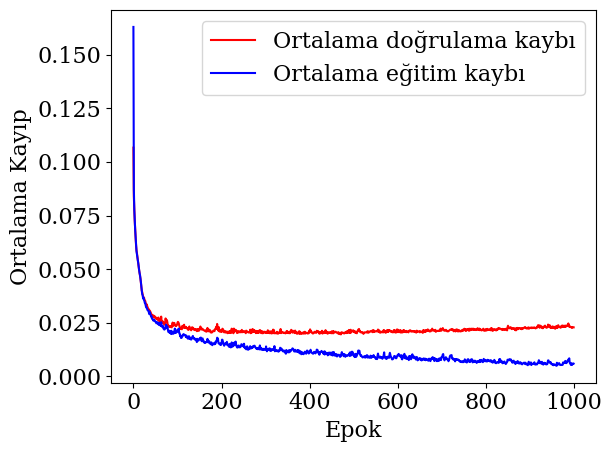

In [510]:
# Kayıpları yükle
losses = np.loadtxt("/content/drive/MyDrive/UAE/results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/UAE/results/average_losses_per_epoch.pdf")
plt.show()

In [511]:
"""!pip uninstall -y plotly kaleido
!pip install plotly==5.24.1 kaleido==0.2.1"""

'!pip uninstall -y plotly kaleido\n!pip install plotly==5.24.1 kaleido==0.2.1'

In [512]:
# y_test: etiketler
X_test, y_test = test_dataset[:]

# z: modelin encoder çıktısı
z, x_hat = model_eval(X_test)

# Tensor'ları NumPy dizisine dönüştür
X_np = z.cpu().detach().numpy()
y_np = y_test.cpu().detach().numpy()

# DataFrame oluşturarak Plotly için uygun hale getir
df = pd.DataFrame({
    'x1': X_np[:, 0],
    'x2': X_np[:, 1],
    'x3': X_np[:, 2],
    'label': y_np.astype(str)  # label'ları string'e çevir
})

# Plot
fig = px.scatter_3d(
    df,
    x='x1',
    y='x2',
    z='x3',
    color='label',
    category_orders={'label': [str(i) for i in range(10)]},  # Doğru sıralama için string liste
    labels={'x1': 'x₁', 'x2': 'x₂', 'x3': 'x₃', 'color': 'Digit'},
    opacity=1.
)

fig.update_layout(
    margin=dict(l=0, r=0, t=20, b=0),
    scene=dict(
        xaxis_title_font=dict(size=30),
        yaxis_title_font=dict(size=30),
        zaxis_title_font=dict(size=30)
    ),
    font=dict(  # Tüm metinlerde geçerli olacak font ayarı
        family='Times New Roman',
        size=15,  # Genel font büyüklüğü
    ),
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5)  # Kamera pozisyonu
    ),
    legend_title_text='Sınıf',
    legend=dict(
        font=dict(size=22),  # Legend içerik yazısı
        title_font=dict(     # Legend başlığı
            family='Times New Roman',
            size=22,
            color='black'
        )
    )
)

fig.update_traces(marker=dict(size=6))
fig.write_image("/content/drive/MyDrive/UAE/results/digits_3d_latent_space.pdf",format="pdf",scale=2)
fig.show()

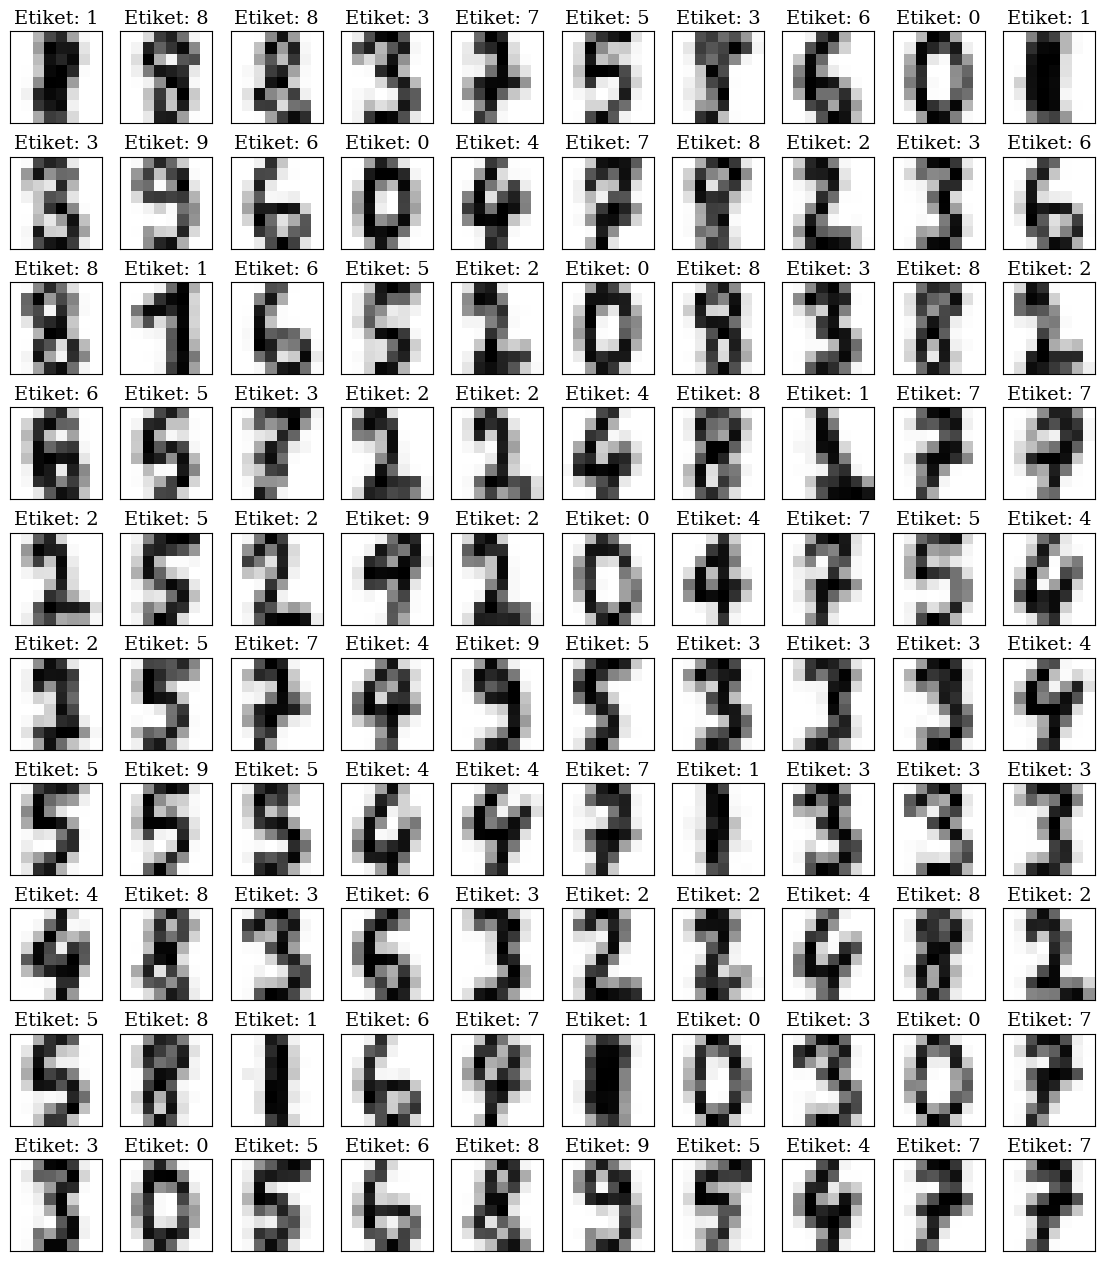

In [513]:
fig, axs = plt.subplots(10, 10, figsize=(14, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].detach().numpy().reshape(8, 8), cmap='binary')
        axs[i, j].set_title(f'Etiket: {y_test[idx]}', fontsize=14)

plt.savefig('/content/drive/MyDrive/UAE/results/digits_mpl_test_verisi.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

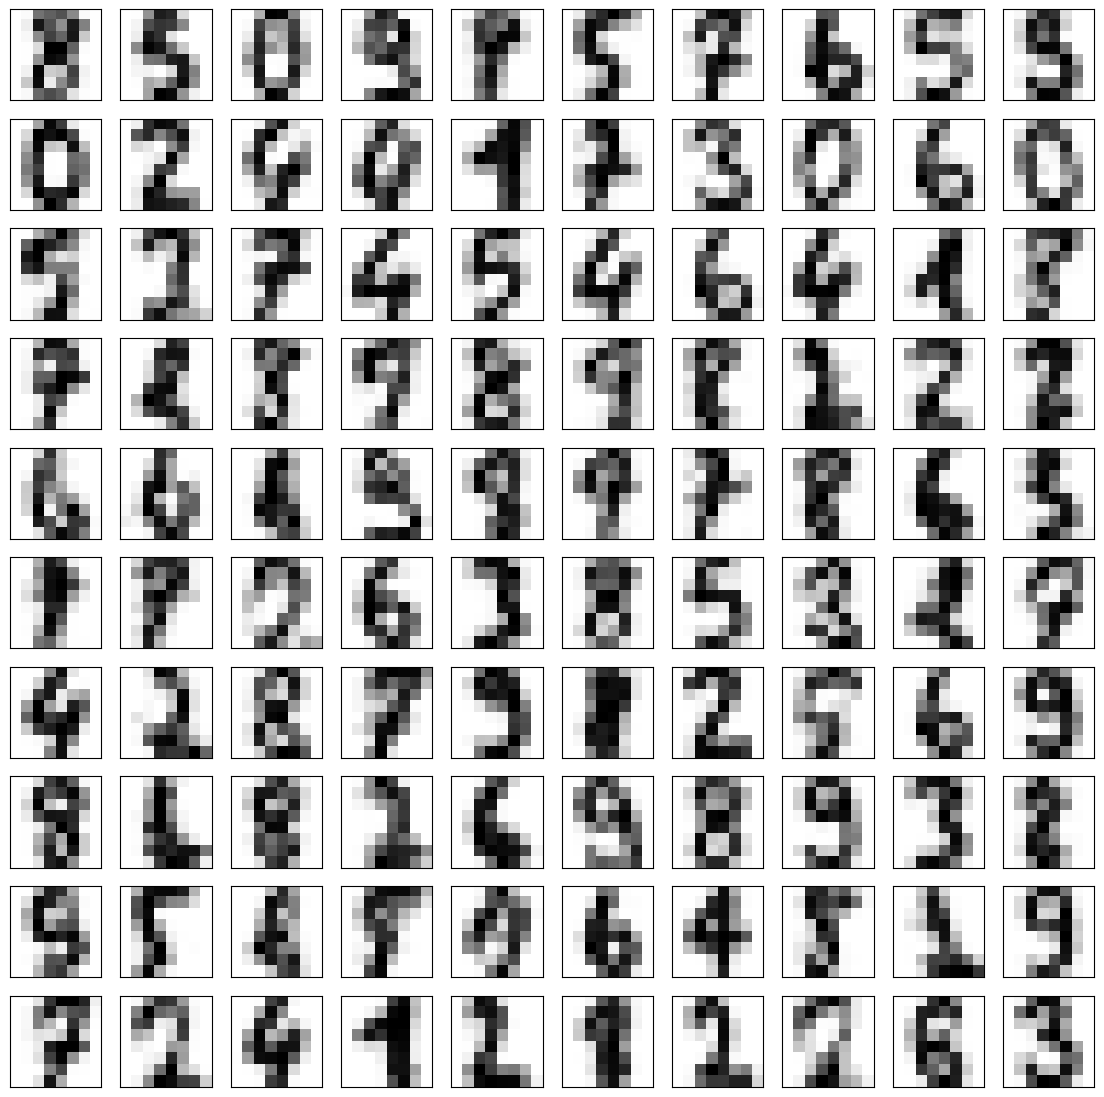

In [514]:
# 3D uniform latent dağılımdan örnek al
uniform_dist = torch.distributions.uniform.Uniform(low=torch.zeros(3), high=torch.ones(3))
latent_samples = uniform_dist.sample((100,))

# Decode et
x_hat = model_eval.decoder(latent_samples)

# Görselleştir
fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    img = x_hat[i].detach().cpu().numpy().reshape(8, 8)
    ax.imshow(img, cmap='binary')

plt.savefig('/content/drive/MyDrive/UAE/results/digits_mlp_veri_uretimi_3d_latent.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

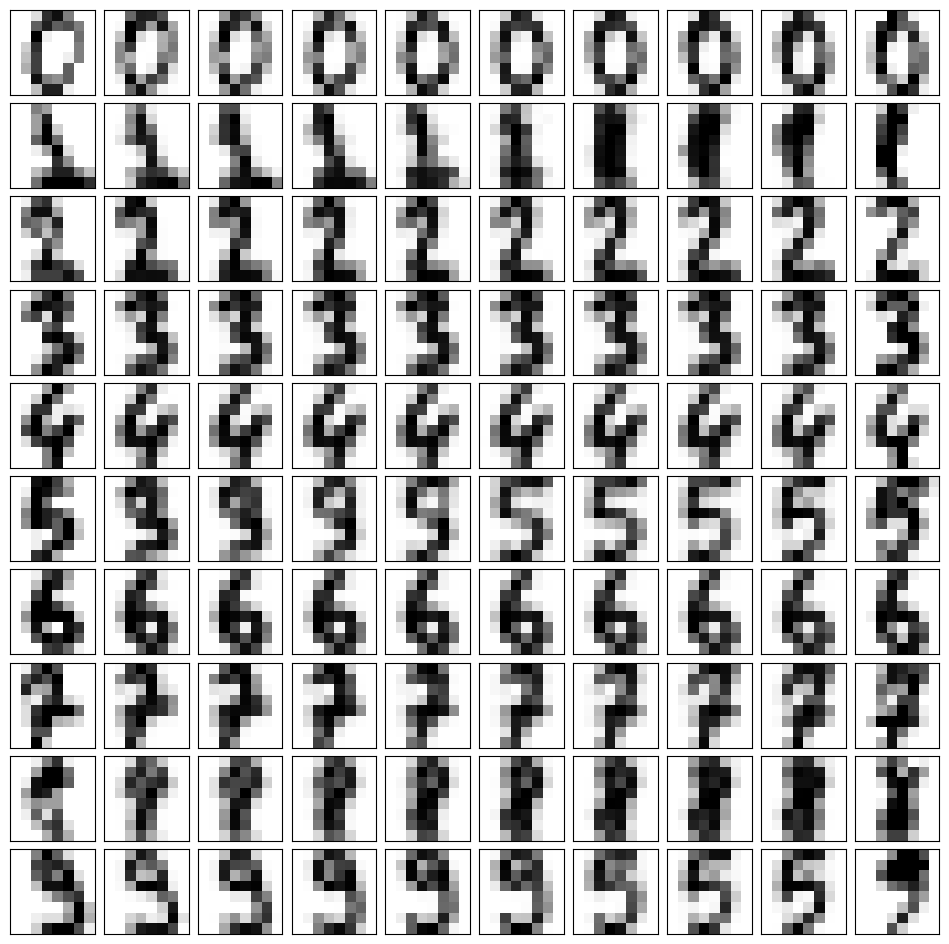

In [515]:
# 3. class_indices sözlüğünü oluştur
class_indices = {label.item(): (y_test == label).nonzero(as_tuple=True)[0] for label in y_test.unique()}

# 5. Interpolasyon fonksiyonu
def digits_interpolation_same_class(model, X_tensor, y_tensor, class_indices, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for row in range(10):
        # Aynı sınıftan 2 örnek seç (sınıf = row)
        label = row
        indices = class_indices[label]
        idx1, idx2 = np.random.choice(indices.cpu(), size=2, replace=False)
        img1 = X_tensor[idx1].unsqueeze(0).to(device)
        img2 = X_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # 1. Görsel: orijinal img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().view(8, 8), cmap='binary')

        # 2. Görsel: decoded img1
        axes[row, 1].imshow(decoded_img1.view(8, 8), cmap='binary')

        # 6 interpolasyon
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.view(8, 8).detach().numpy(), cmap='binary')

        # 9. Görsel: decoded img2
        axes[row, 8].imshow(decoded_img2.view(8, 8), cmap='binary')

        # 10. Görsel: orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().view(8, 8), cmap='binary')

    plt.savefig('/content/drive/MyDrive/UAE/results/digits_same_class_interpolation_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

# 6. Fonksiyonu çalıştır
digits_interpolation_same_class(model_eval, X_test, y_test, class_indices, device='cpu')

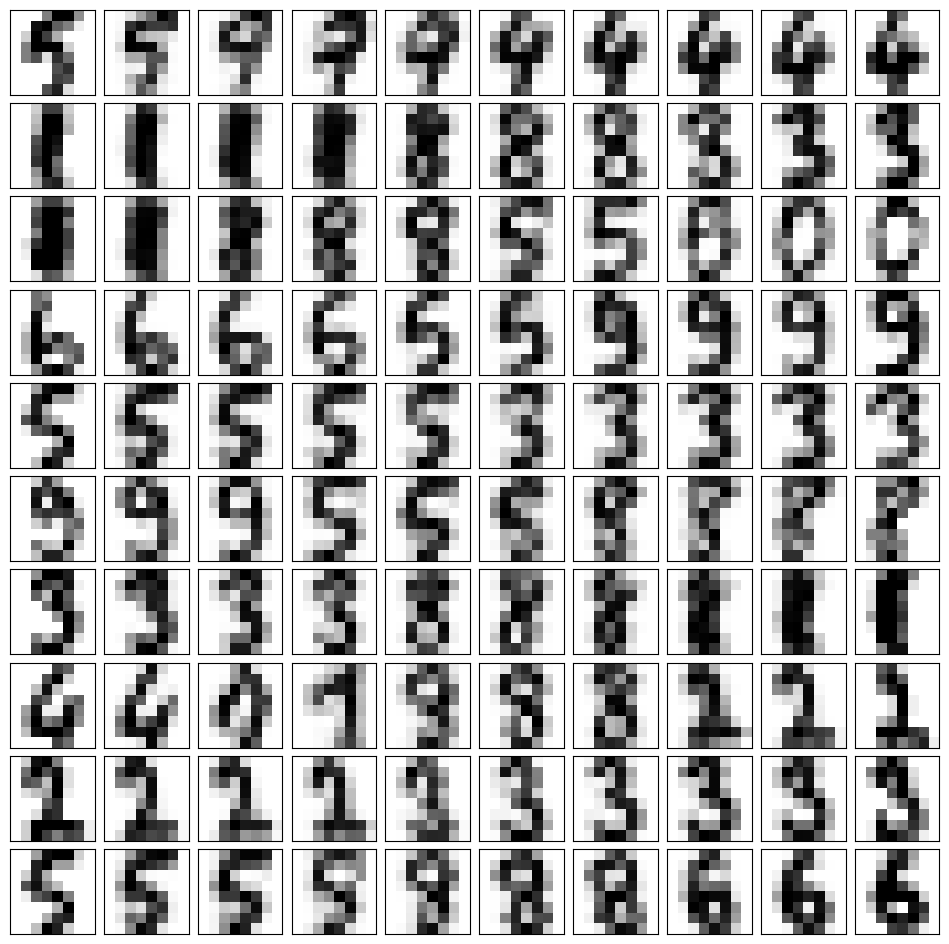

In [516]:
def digits_interpolation_grid(model, data_tensor, labels_tensor, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    labels_np = labels_tensor.cpu().numpy()

    for row in range(10):
        # Farklı sınıflardan iki örnek seç
        while True:
            idx1 = torch.randint(0, len(data_tensor), (1,)).item()
            idx2 = torch.randint(0, len(data_tensor), (1,)).item()
            if labels_np[idx1] != labels_np[idx2]:
                break

        img1 = data_tensor[idx1].unsqueeze(0).to(device)
        img2 = data_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # Orijinal img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().view(8, 8), cmap='binary')

        # decoded(img1)
        axes[row, 1].imshow(decoded_img1.view(8, 8), cmap='binary')

        # Ara interpolasyonlar
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.view(8, 8).detach().numpy(), cmap='binary')

        # decoded(img2)
        axes[row, 8].imshow(decoded_img2.view(8, 8), cmap='binary')

        # Orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().view(8, 8), cmap='binary')

    plt.savefig('/content/drive/MyDrive/UAE/results/digits_interpolation_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

digits_interpolation_grid(model_eval, X_test, y_test, device='cpu')

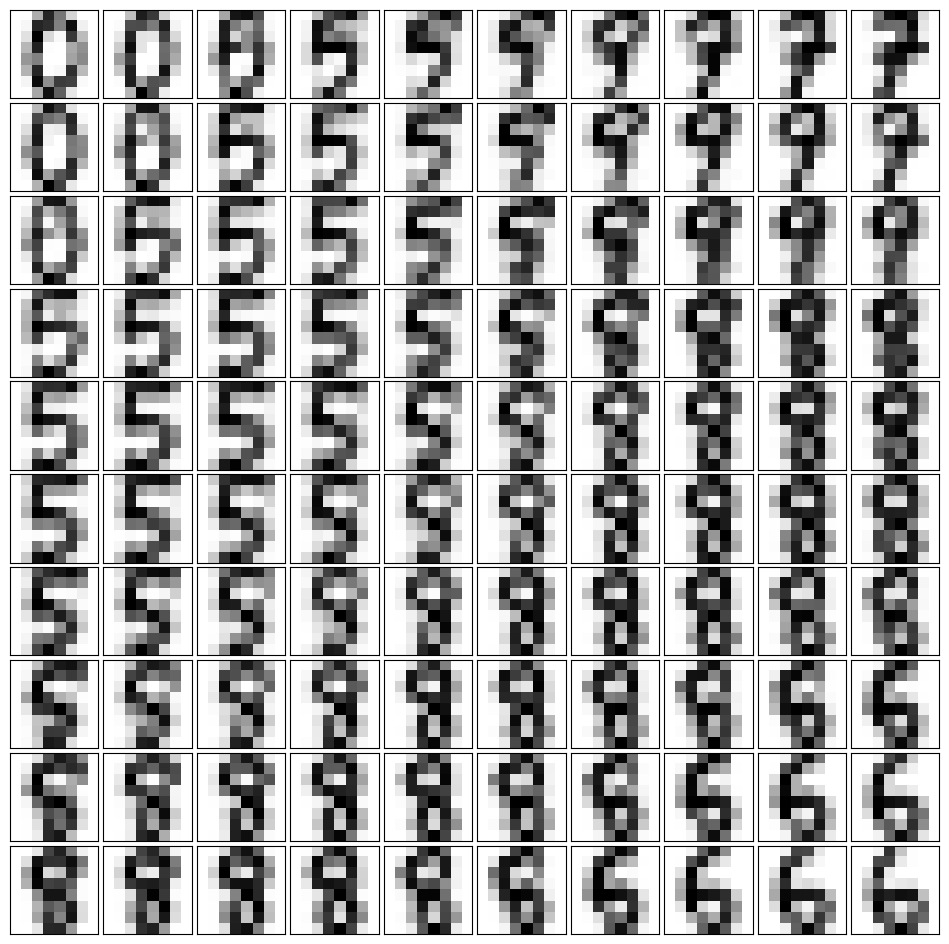

In [517]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import os

def bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y):
    """x: yatay eksende 0-1, y: düşey eksende 0-1"""
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

def digits_corner_interpolation(model, data_tensor, labels_tensor, device='cpu'):
    model.to(device)
    model.eval()

    labels_np = labels_tensor.cpu().numpy()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels_np):
        class_indices[label].append(idx)

    classes = list(class_indices.keys())
    selected_classes = np.random.choice(classes, size=4, replace=False)

    # 4 farklı sınıftan birer örnek seç (indeks ve etiket)
    idx_tl = np.random.choice(class_indices[selected_classes[0]])
    idx_tr = np.random.choice(class_indices[selected_classes[1]])
    idx_bl = np.random.choice(class_indices[selected_classes[2]])
    idx_br = np.random.choice(class_indices[selected_classes[3]])

    # Köşelerin bilgileri
    corner_info = {
        'Top-Left':  (idx_tl, selected_classes[0]),
        'Top-Right': (idx_tr, selected_classes[1]),
        'Bottom-Left': (idx_bl, selected_classes[2]),
        'Bottom-Right': (idx_br, selected_classes[3])
    }

    # TXT dosyasına yaz
    os.makedirs("/content/drive/MyDrive/UAE/results", exist_ok=True)
    with open("/content/drive/MyDrive/UAE/results/corner_digits_info.txt", "w") as f:
        f.write("Köşe interpolasyonu için seçilen örnekler:\n\n")
        for corner, (idx, label) in corner_info.items():
            f.write(f"{corner}: indeks = {idx}, sınıf = {label}\n")

    # Görselleri al
    img_tl = data_tensor[idx_tl].unsqueeze(0).to(device)
    img_tr = data_tensor[idx_tr].unsqueeze(0).to(device)
    img_bl = data_tensor[idx_bl].unsqueeze(0).to(device)
    img_br = data_tensor[idx_br].unsqueeze(0).to(device)

    with torch.no_grad():
        z_tl = model.encoder(img_tl)
        z_tr = model.encoder(img_tr)
        z_bl = model.encoder(img_bl)
        z_br = model.encoder(img_br)

    # Görselleştirme için grid oluştur
    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    for i in range(10):
        for j in range(10):
            x = j / 9.0  # yatay interpolasyon katsayısı
            y = i / 9.0  # düşey interpolasyon katsayısı
            z_interp = bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y)
            with torch.no_grad():
                img = model.decoder(z_interp).squeeze(0).cpu().view(8, 8)
            axes[i, j].imshow(img.numpy(), cmap='binary')

    plt.savefig('/content/drive/MyDrive/UAE/results/digits_corner_interpolation.pdf', format='pdf',
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()


digits_corner_interpolation(model_eval, X_test, y_test, device='cpu')

# makale için ingilizceye çevirdim


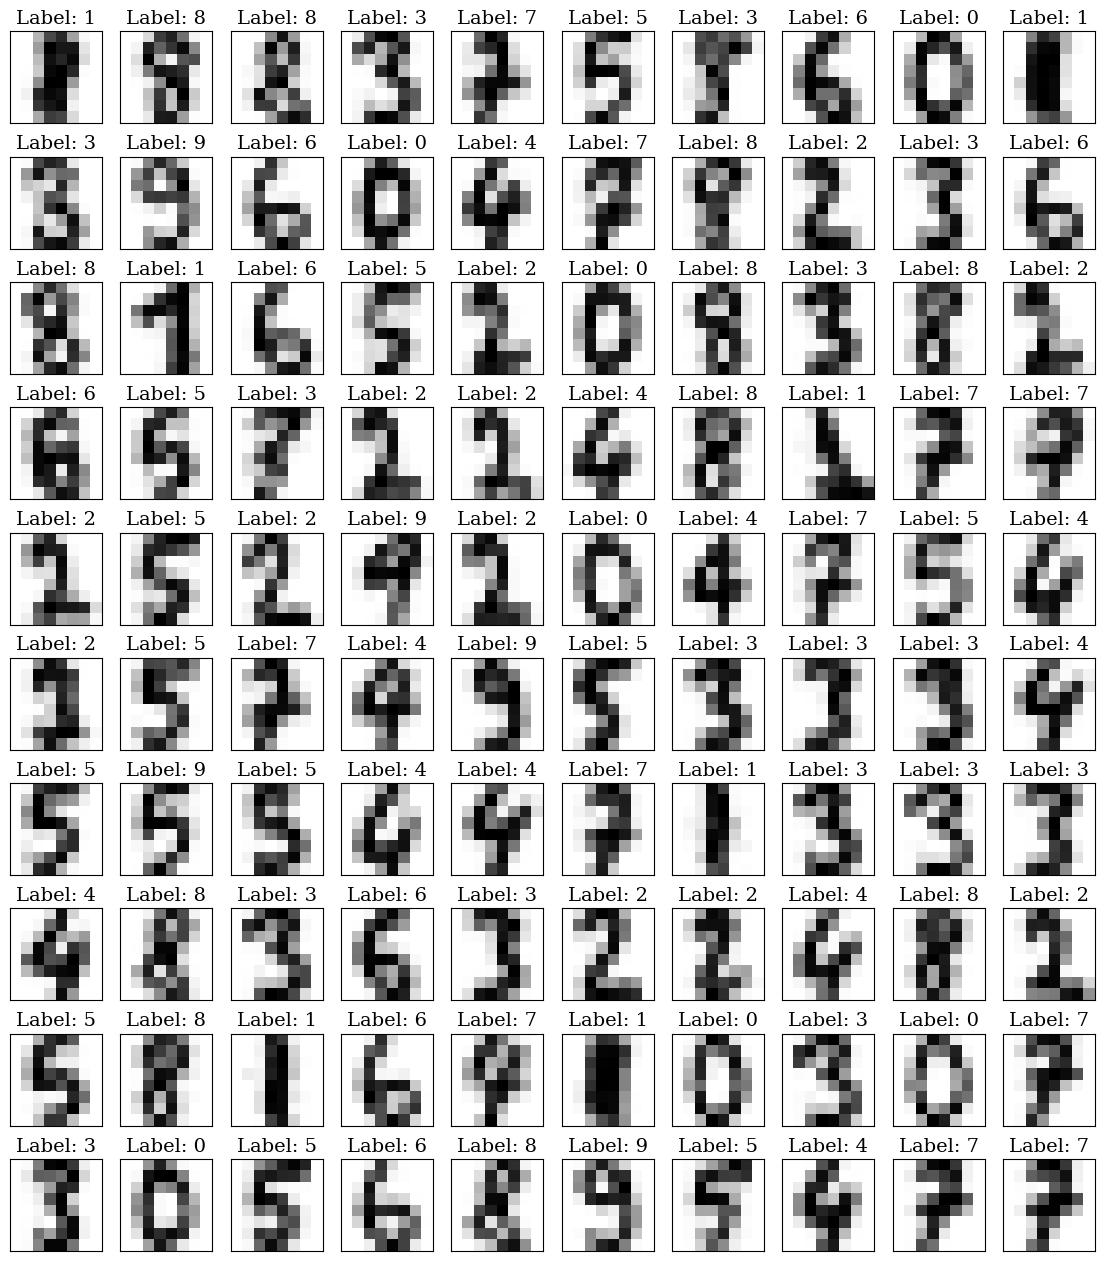

In [518]:
# y_test: etiketler
X_test, y_test = next(iter(test_loader))

# z: modelin encoder çıktısı
z, x_hat = model_eval(X_test)

fig, axs = plt.subplots(10, 10, figsize=(14, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].detach().numpy().reshape(8, 8), cmap='binary')
        axs[i, j].set_title(f'Label: {y_test[idx]}', fontsize=14)

plt.savefig('/content/drive/MyDrive/UAE/results/digits_mpl_test_verisi_label.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()